In [1]:
# Import modules
import sys
sys.path.append("../code/")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader

from swag import SWAG
from models import Classification_relu, Classification_sigmoid, Classification_tanh, Classification_relu_8
from util import plot_decision_boundary, uncertainty_measurement
from data_gen import ClassificationDataSet, TwoMoons

torch.manual_seed(0)
np.random.seed(0)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def swag_trainer(NN_class,
                 swa_const_lr=1,
                 K=10,
                 train_epoch=20,
                 n_models=100,
                 log_freq=60,
                 verbose=False,
                 xlim=6,
                 ax=None): 
    """ The main training loop of SWAG.
        Params:
            NN_class: class of the NN model
            swa_const_lr=1: swag inference learning rate
            K=10: number of columns for the SWAG Deviation Matrix
            train_epoch=20: number of training epoches
            log_freq=60: logging frequency for training
            verbose=False: whether to print training logs
            n_models=100: number of models to plot
            xlim=6: xlim of the plot for decision boundary
            ax=None: axis on which the decision boundary will be plotted
            
    """
    torch.manual_seed(47)
    np.random.seed(47)

    # Initialize SWAG
    swag = SWAG(NN_class, K=K)
    print("Total number of parameters for the NN is:", swag.weigt_D)

    # Compile swag
    objective = 'classification'
    lr = 3e-2
    momentum = 0.9
    optimizer = optim.SGD
    loss_fn = nn.CrossEntropyLoss()
    swa_scheduler = LambdaLR

    swag.compile(objective, lr, swa_const_lr, momentum, optimizer, loss_fn, swa_scheduler)

    # Fit swag
    first_mom, second_mom, D = swag.fit(train_gen,
                                        train_epoch=train_epoch,
                                        swag_epoch=20,
                                        log_freq=log_freq,
                                        verbose=verbose)

    # measure uncertainty
    expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
    uncertainty_measurement(X_test, expand_pred)
    
    # Plot decision boundary
    print("\nPlotting the decision boundaries...")
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plot_decision_boundary(swag, X, y, ax, xlim, n_models, poly_degree=1, test_points=X_test, shaded=True)
    return swag

# Classification on a toy dataset

Since the paper proposed that the SWAG algorithm will be able to closely approximate the posterior of neural networks, we would like to apply this idea to a simple task of OOD detection. 

In the below section, we will apply SWAG to a really simple dataset borrowed from HW7 for OOD detection. Specifically, we have strategically selected a number of points to evaluate the model's ability to capture aleatoric and epistemic uncertainties. The expected behavior for the test points are described as the follows:
- `(-1, -1.5), (1, 1)`: in-distribution samples, should be classified corrected with high certainty
- `(-5, -5), (5, 5)`: OOD samples, designed to test model's ability to capture epistemic uncertainty and should be assigned high uncertainty in prediction
- `(-5, 3.5), (5, -3.5)`: OOD samples, should be assigned high uncertainty in prediction. Note that these two points are roughly right on top of the linear decision boundary that separates the two classes, which means correctly assigning epistemic uncertainties is more challenging
- `(-1, 1), (1, -1)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the decision boundary of the two classes

In [3]:
# Create the training DataSet
train_data = ClassificationDataSet(n_samples=500, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 8, shuffle = False)

X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

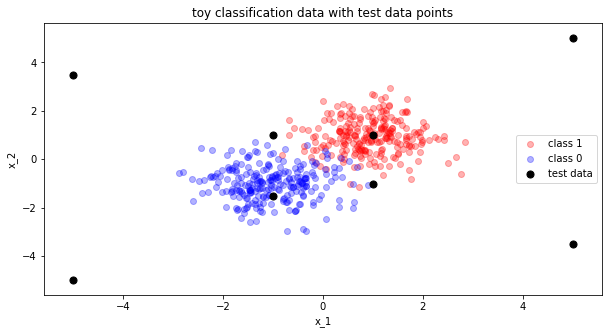

In [4]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [5]:
# Take a look at the architecture of Classification_NN
Classification_relu()

Classification_relu(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)

In [6]:
# Initialize SWAG
swag = SWAG(Classification_relu, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

# Compile swag
objective = 'classification'
lr = 3e-3
swa_const_lr = 1
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR

swag.compile(objective, lr, swa_const_lr, momentum, optimizer, loss_fn, swa_scheduler)

Total number of parameters for the NN is: 42


In [7]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=30,
                                    swag_epoch=20,
                                    log_freq=60)

Begin NN model training...
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.7292
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.5846
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.4737
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.4213
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.3900
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.3730
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.3639
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.3587
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.3554
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.3532
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.3516
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.3504
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.3495
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3488
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3482
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3477
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3473
[Epoch: 18, 	Iteration:    60] 	Training Loss: 0.3469
[Epoch: 19

## Uncertainty Measurement

One way to approximate the model uncertainty, is by measuring the variance (or standard deviation) of the model predictions for each point. We can repeatedly draw samples from the SWAG weights posterior to form a distribution over predictions for each point. The expected behavior is that, for the OOD points, the variance of predictions should be higher than for the in-sample points. The precise defition on uncertainty, $U$, in this case is:

$$
U(y) = Var(\{\hat{y_i}, i\in ~[1,2,3,...S]\})
$$

where $y$ is the origianl data point, $y_i$ is the $i^{th}$ prediction using a particular set of sample weights, and $S$ is the number of sample weights drawn from the posterior formed by SWAG.

To measure this uncertainty, we wrote a function that, in prediction time, perserves all of the predictions using each of the sampled weights.

In [8]:
# Sample 1000 posterior weights
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
print("Shape of the expanded prediction:\n", expand_pred.shape)
print("Predictions for each point using the 1st sample weights:\n", expand_pred[0])

Shape of the expanded prediction:
 (100, 8, 2)
Predictions for each point using the 1st sample weights:
 [[9.99198496e-01 8.01559130e-04]
 [2.17321576e-04 9.99782741e-01]
 [1.00000000e+00 5.53933877e-09]
 [1.68384051e-13 1.00000000e+00]
 [9.90776360e-01 9.22370981e-03]
 [5.91326021e-02 9.40867364e-01]
 [2.36127004e-01 7.63872981e-01]
 [6.94613218e-01 3.05386722e-01]]


In [9]:
# Measure Uncertainty
uncertainty_measurement(X_test, expand_pred)


Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.0291
Test point: (5, -3.5) 	Variance in prediction: 0.0736
Test point: (-1, 1) 	Variance in prediction: 0.0979
Test point: (1, -1) 	Variance in prediction: 0.2016


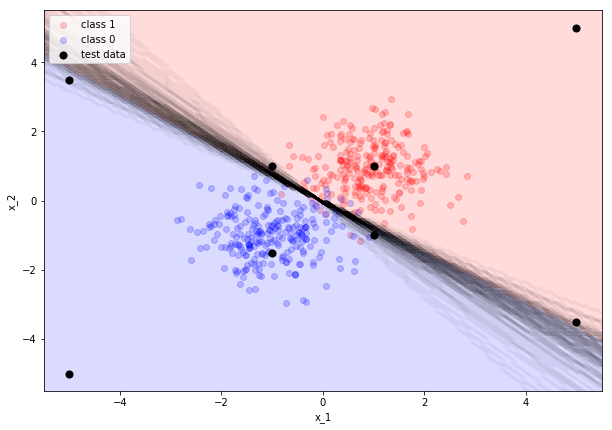

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, xlim=6, n_models=100, poly_degree=1, test_points=X_test, shaded=True)

From the above uncertainty measurements, we see that the uncertainty measurement is only positive for the 4 data points that lie right on top of the decision boundary, while the 2 off-diagnol OOD points have no uncertainty whatsoever, which is undesirable.

To counter this problem, we will explore a number of possibilities
1. use different activation functions - the intuition is that using different activation function could produce different decision boundaries, some of which might produce better uncertainty measurements
2. perform the pre-training for less epochs - the idea is that if the pre-trained model is already overfitted, then the swag inference will tend to produce very similar results, so underfitting the pre-trained model could potentially produce more desirable uncertainty measurements
3. experiment with the learning rate for swag inference - the idea is that if we vary the learning rate during swag inference, the model might explore more or less of the subspace formed by the NN weights, which could yield better uncertainty measurements
4. change the parameter $K$, which controls the number of columns within the deviation matrix $D$ of the swag algorithm. A larger $K$ could mean that there will be more variance within the sampled weights.

## Experiment 1. Different activation functions

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.2176
Test point: (5, -3.5) 	Variance in prediction: 0.1924
Test point: (-1, 1) 	Variance in prediction: 0.0979
Test point: (1, -1) 	Variance in prediction: 0.2451

Plotting the decision boundaries...


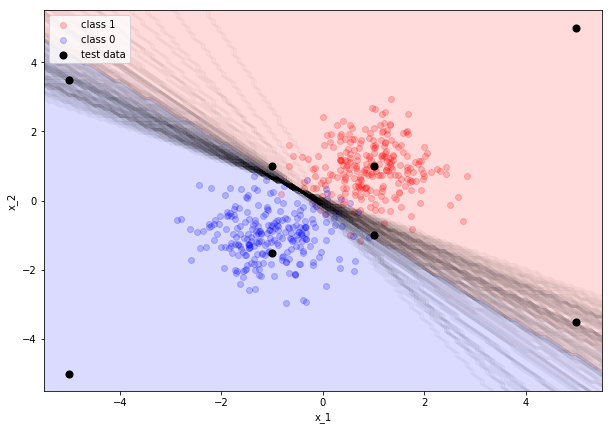

In [11]:
# Try sigmoid activation
swag = swag_trainer(Classification_sigmoid)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.0384
Test point: (5, -3.5) 	Variance in prediction: 0.0564
Test point: (-1, 1) 	Variance in prediction: 0.0000
Test point: (1, -1) 	Variance in prediction: 0.0000

Plotting the decision boundaries...


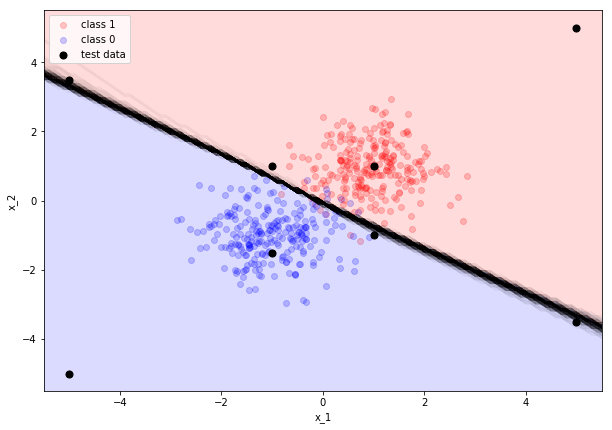

In [12]:
# Try tanh activation
swag = swag_trainer(Classification_tanh, train_epoch=10)

We can see from the above two visualization as well as the uncertainty measurements that, even though the decision boundaries produced by the sigmoid and tanh functions are somewhat different than those produced by the NN base model using relu activation, one predominant theme we still observe is that, if the neural network is overfitted to the dataset, the posterior weights sampled using SWAG tend to produce decision boundaries that are similarily tightly centered around the linear decision boundary that separates the two classes. 

At the same time, the uncertainty measures are not ideal, only capturing the uncertainties for `(-1, 1), (1, -1)`, which were designed to capture aleatoric uncertainties, and `(-5, 3.5), (5, -3.5)` (which lie on the extension of the linear decision boundary), which were designed to capture epistemic uncertainties. However, we notice that `(-5, -5), (5, 5)`, which are orthogonal to the linear decision boundary, have zero uncertainty, which means the SWAG model failed to capture these two OOD samples.

## Experiment 2. Underfitting the pre-trained model

Continuing with our experiment, we will now explore underfitting the pre-trained model to see if this will mitigate the undesirable uncertainty measurements. We will employ the `Classification_the sigmoid` model since, compared to the other two NNs, its ability to produce desirable uncertainty measurements is slightly better.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0819
Test point: (1, 1) 	Variance in prediction: 0.1539
Test point: (-5, -5) 	Variance in prediction: 0.0384
Test point: (5, 5) 	Variance in prediction: 0.1539
Test point: (-5, 3.5) 	Variance in prediction: 0.2211
Test point: (5, -3.5) 	Variance in prediction: 0.2436
Test point: (-1, 1) 	Variance in prediction: 0.2016
Test point: (1, -1) 	Variance in prediction: 0.1875

Plotting the decision boundaries...


/Users/zihaoxu/ENTER/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


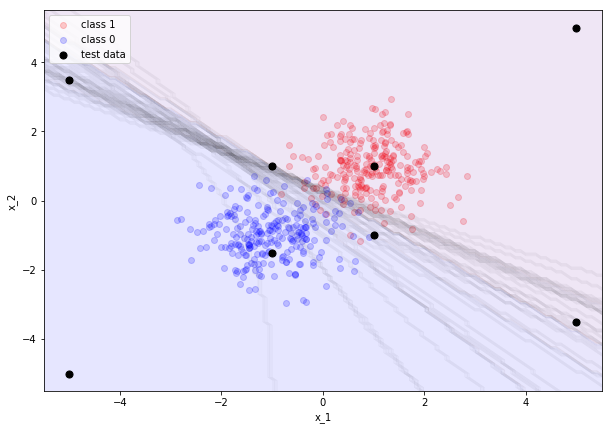

In [13]:
# Train for 5 epochs
swag = swag_trainer(Classification_sigmoid, train_epoch=5, n_models=50)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0564
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0564
Test point: (-5, 3.5) 	Variance in prediction: 0.2331
Test point: (5, -3.5) 	Variance in prediction: 0.2451
Test point: (-1, 1) 	Variance in prediction: 0.1411
Test point: (1, -1) 	Variance in prediction: 0.2419

Plotting the decision boundaries...


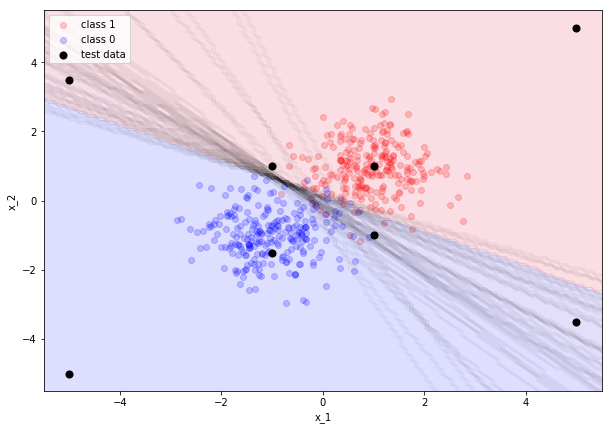

In [14]:
# Train for 10 epochs
swag = swag_trainer(Classification_sigmoid, train_epoch=10, n_models=50)

In [15]:
# Predicting all X_test
for i in range(20):
    preds = swag.predict(torch.Tensor(X_test), [0, 1], S=1, expanded=False)
    print("Trail", i, ', Predictions:', preds)

Trail 0 , Predictions: [0 0 0 0 0 0 0 0]
Trail 1 , Predictions: [0 1 0 1 1 0 1 0]
Trail 2 , Predictions: [0 1 0 1 1 0 1 0]
Trail 3 , Predictions: [0 1 0 1 0 1 1 1]
Trail 4 , Predictions: [0 1 0 1 0 1 0 0]
Trail 5 , Predictions: [0 1 0 1 1 0 1 0]
Trail 6 , Predictions: [0 0 0 0 0 0 0 0]
Trail 7 , Predictions: [0 1 0 1 0 1 0 1]
Trail 8 , Predictions: [0 1 0 1 0 1 1 0]
Trail 9 , Predictions: [0 1 0 1 1 0 1 0]
Trail 10 , Predictions: [0 1 0 1 0 1 1 1]
Trail 11 , Predictions: [0 1 0 1 1 0 1 0]
Trail 12 , Predictions: [0 1 0 1 0 1 1 0]
Trail 13 , Predictions: [0 1 0 1 0 1 1 1]
Trail 14 , Predictions: [0 1 0 1 1 0 1 0]
Trail 15 , Predictions: [0 1 0 1 1 0 1 0]
Trail 16 , Predictions: [0 1 0 1 1 0 1 0]
Trail 17 , Predictions: [0 1 0 1 1 0 1 0]
Trail 18 , Predictions: [0 1 0 1 0 1 1 1]
Trail 19 , Predictions: [0 1 0 1 1 0 1 0]


In [16]:
# Predicting just one point
pt = (1, 1)
point_pred = swag.predict(torch.Tensor(pt).view(1,-1), [0, 1], S=100, expanded=True)[:, 0, :]
point_pred = np.argmax(point_pred, axis=1)
print(f"For {pt}, mean prediction: {np.mean(point_pred):.4f}, var of predictions: {np.var(point_pred):.4f}")

pt = (5, 5)
point_pred = swag.predict(torch.Tensor(pt).view(1,-1), [0, 1], S=100, expanded=True)[:, 0, :]
point_pred = np.argmax(point_pred, axis=1)
print(f"For {pt}, mean prediction: {np.mean(point_pred):.4f}, var of predictions: {np.var(point_pred):.4f}")

For (1, 1), mean prediction: 0.9300, var of predictions: 0.0651
For (5, 5), mean prediction: 0.9100, var of predictions: 0.0819


From the above experiments, we find that underfitting the pre-tarined model is not a good idea. This is because even though underfitting might be able to produce more "curved" decision bounaries (which could be desirable), the recontructed NN also tends to be more unstable as the sampled posterior weights will produce enitrely non-sensible results such as predicting all 1s or all 0s for the test points. This is evident form the above two calulations:
- For repeated predictions of all test points, we see some big stability issues with the model since we observe some predictions to be all 0s or all 1s
- `(1, 1), (5, 5)` are two points that the model should seemingly be really certain of, but their uncertainties are not zero, which indicates that the model suffers from unstability

We have two hypotheses that could explain this observation:
1. for neural network models in general, the non-linear relationships between the neurons in the hidden layers are so complex that sometimes even a small tweek in the model weights will make the predictions non-sensible
2. due to the stochasticity of the SWAG model, sometimes the sampled the posterior weights could deviation from the pre-trained weights by a substantial amount that the re-constructed NN will produce non-sensible results

## Experiment 3. SWAG learning rate

Another paramter that we could experiment with is the learning rate during SWAG inference. In the original paper, the author proposed using a constant learning rate for the SWAG inference to explore the subspace formed by the posterior of NN weights. In our original implementation, we used a constant learning rate of 1, but now we could try larger learning rates to see if the exploration could be more thorough.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0196
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0196
Test point: (-5, 3.5) 	Variance in prediction: 0.2491
Test point: (5, -3.5) 	Variance in prediction: 0.2244
Test point: (-1, 1) 	Variance in prediction: 0.0651
Test point: (1, -1) 	Variance in prediction: 0.2484

Plotting the decision boundaries...


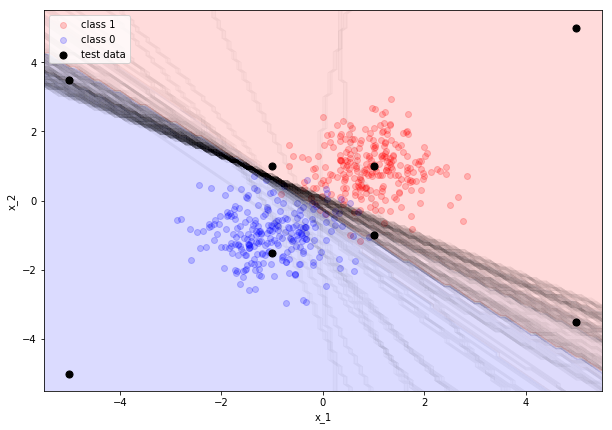

In [17]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=3)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0819
Test point: (1, 1) 	Variance in prediction: 0.0196
Test point: (-5, -5) 	Variance in prediction: 0.0475
Test point: (5, 5) 	Variance in prediction: 0.0196
Test point: (-5, 3.5) 	Variance in prediction: 0.1924
Test point: (5, -3.5) 	Variance in prediction: 0.2379
Test point: (-1, 1) 	Variance in prediction: 0.0196
Test point: (1, -1) 	Variance in prediction: 0.2496

Plotting the decision boundaries...


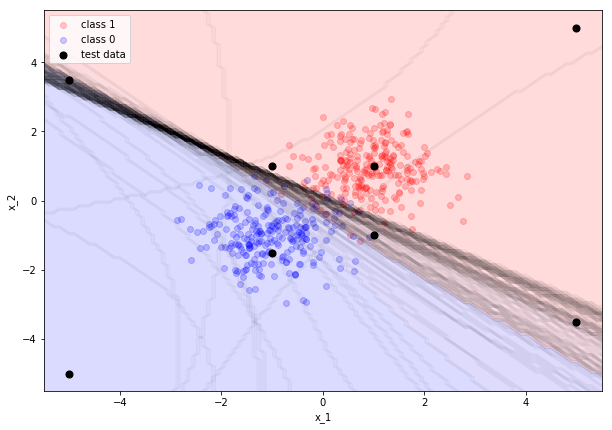

In [18]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=5)

From the above results, we see that change the SWAG inference learning rate can only amplify the test points that already have a reasonable uncertainty, but cannot correctly assign uncertainties to those points that should have been assigned a non-trival uncertainty. Also, if the learning rate is too large, the resulting model is highly unstable, yielding highly unstable predictions and non-sensible uncertainty measures.

## Experiment 4. K

Finally, we will experiemnt with the parameter $K$, which controls the number of columns in the deviation matrix of the SWAG inference.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.2211
Test point: (5, -3.5) 	Variance in prediction: 0.1539
Test point: (-1, 1) 	Variance in prediction: 0.0000
Test point: (1, -1) 	Variance in prediction: 0.1411

Plotting the decision boundaries...


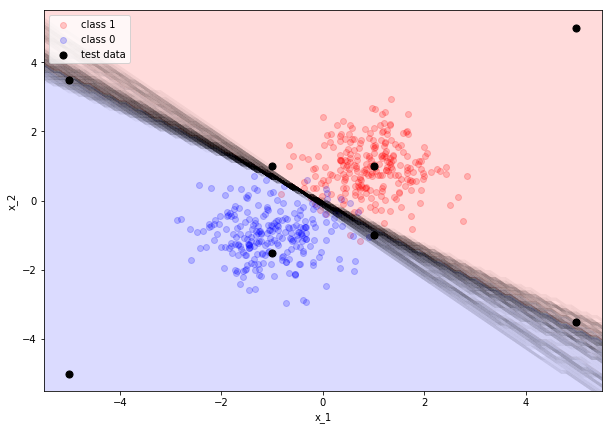

In [19]:
swag = swag_trainer(Classification_sigmoid, K=5)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0475
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0475
Test point: (-5, 3.5) 	Variance in prediction: 0.2419
Test point: (5, -3.5) 	Variance in prediction: 0.2436
Test point: (-1, 1) 	Variance in prediction: 0.1411
Test point: (1, -1) 	Variance in prediction: 0.1971

Plotting the decision boundaries...


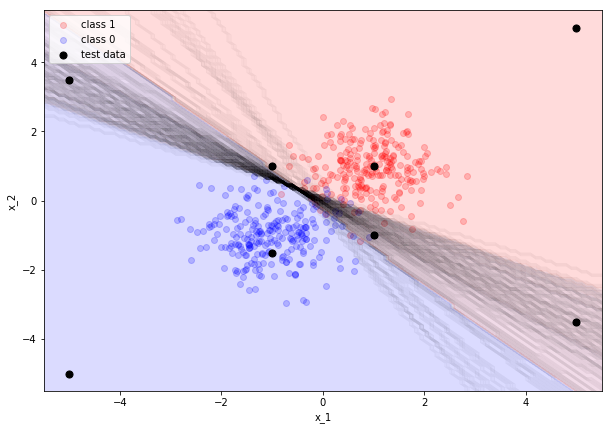

In [20]:
swag = swag_trainer(Classification_sigmoid, K=15)

From the above exploration, we see that increasing $K$ does have the effect of increasing the spread, or uncertainty, but the shapes of the decision boundaries do not change or the original one, which means we still failed to detect OOD observations.

## Further Explorations

In additional to the simple two-cluster dataset, we would like to apply SWAG on a more interesting dataset, Two Moons (Pedregosa et al., 2011), to see how the posterior inference behaves in cases where the decision boundary is more complex.

In this experiment, we designed the following test points:
- `(1, -.5), (0, 1)`: in-distribution samples, should be classified corrected with high certainty
- `(-0.5, 0.25), (0.5, 0.25), (1.5, 0.25)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the decision boundary of the two classes
- `(-1, -1,5), (-1, 1.5), (2, -1.5), (2, 1.5)`: OOD samples, designed to test model's ability to capture epistemic uncertainty and should be assigned high uncertainty in prediction

In [21]:
# Create the training DataSet
train_data = TwoMoons(n_samples=500, mode='train', noise=0.1)
train_gen = DataLoader(dataset = train_data, batch_size=32)

X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

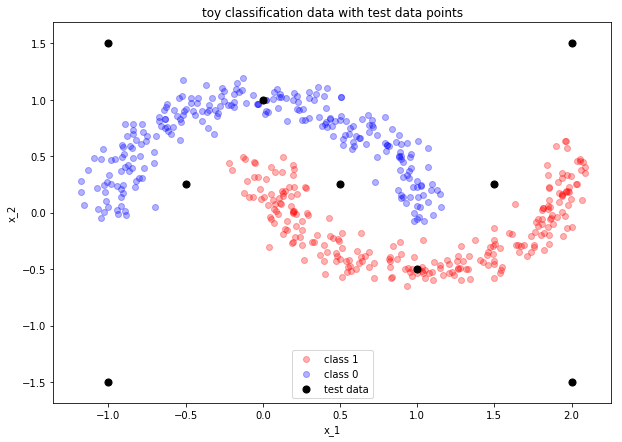

In [22]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

Total number of parameters for the NN is: 70
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (1, -0.5) 	Variance in prediction: 0.0000
Test point: (0, 1) 	Variance in prediction: 0.0000
Test point: (-0.5, 0.25) 	Variance in prediction: 0.0000
Test point: (0.5, 0.25) 	Variance in prediction: 0.0099
Test point: (1.5, 0.25) 	Variance in prediction: 0.0000
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (-1, 1.5) 	Variance in prediction: 0.0000
Test point: (2, -1.5) 	Variance in prediction: 0.0000
Test point: (2, 1.5) 	Variance in prediction: 0.0000

Plotting the decision boundaries...


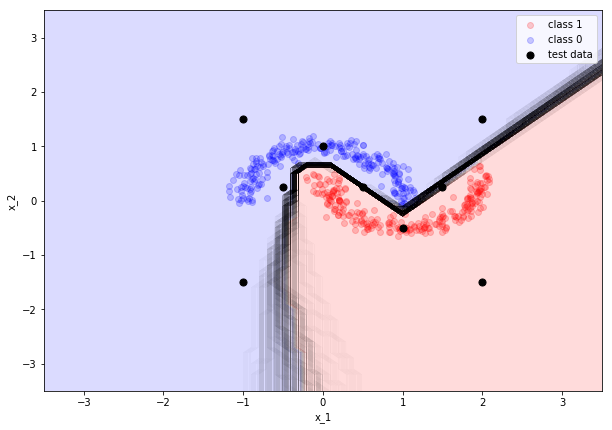

In [23]:
swag = swag_trainer(Classification_relu_8, train_epoch=80, verbose=False, log_freq=10, xlim=4)

From the uncertainty measures and the plot of decision boundaries, we see that the model is able to separate the data quite well, however, the model did not bother to form any curvature around the dataset and just did the "bare minimum" to separate the two classes. Again, the OOD points do not have any epistemic uncertainties, and even the points desinged to test model aleatoric uncertainties do not have non-trivial uncertainties in their predictions. This means that, again, SWAG failed to produce desirable uncertainty measurements and still suffers from the shortcoming discussed above.

## Conclusion

In the above section, we have thoroughly explore the ability of SWAG to produce uncertainty measurements. The overall result is not perfect, as the model is only able to capture aleatoric uncertainty (as well as those points that happen to lie right on top of the linear decision boundary), but not the epistemic uncertainty for OOD test points.

This analysis points out several important limitations of the SWAG algorithm:
- Due to the **"black box" nature of NN models**, it is hard for us to understand the effect of changing the model parameters, which means **the expected behavior** of approximating the posterior of NN weights as a multivariate normal distirbution and then sample from it **is very hard to predict**. As we have seen from the examples above, the re-constrcuted model using sampled weights could sometimes be highly unstable and yield non-sensible predictions like all 0s or all 1s (predicting all observations belonging to the same class)
- It is well knowm that **NN models has the potential to overfit to the training data**, and this is indeed what we observe. If the pre-trained model is too overfitted, then the SWAG inference step could only **produce models that are very similar to the original model**, which undermines the SWAG model's ability to capture the desired amount of uncertainty
- The ability of the SWAG model to capture uncertainty is ultimately bounded by the shape of decision boundaries that the original NN could form. An interesting observation is that **NN models**, even with their ability to form arbitrarily complex decision boundaries, do not tend to produce decision boundaries that "surrounds" the data points, but rather **tend to produce pretty simple decision boundaries (e.g., linear) that best separates the data**. Therefore, to better capture uncertainty for this particular toy dataset, we should probably use higher order polynomial transformation of the features
- Even though the uncertainty measurements were not ideal, we learned that to **increase the spread of the model predictions**, we could **crank up `$K$` or the `SWAG inference learning rate`** to achieve this. However, underfitting the pre-trained model is almost always not a good idea.